<a href="https://colab.research.google.com/github/ahmadalideeb/YOLOv2-Object-Detection/blob/main/YOLO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import argparse
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/YOLO2/yolo')
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    box_scores = box_confidence*box_class_probs   # tensor of shape (19, 19, 5, 80)
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores,axis=-1)   # tensor of shape (19, 19, 5, 1)
    box_class_scores = K.max(box_scores,axis=-1)    # tensor of shape (19, 19, 5, 1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = (box_class_scores>threshold)    # tensor of shape (19, 19, 5, 1)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores, boxes, classes

In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)
    
    return scores, boxes, classes

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=25, score_threshold=.3, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes,iou_threshold=iou_threshold)
    
    
    return scores, boxes, classes

In [7]:
sess = K.get_session()

In [8]:
class_names = read_classes("/content/gdrive/MyDrive/Colab Notebooks/YOLO2/yolo/model_data/coco_classes.txt")
anchors = read_anchors("/content/gdrive/MyDrive/Colab Notebooks/YOLO2/yolo/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [9]:
yolo_model = load_model("/content/gdrive/MyDrive/Colab Notebooks/YOLO2/yolo/model_data/yolo.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [10]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [12]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape, max_boxes=80, score_threshold=.05, iou_threshold=.02)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
import imageio

In [14]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("/content/gdrive/MyDrive/Colab Notebooks/YOLO2/yolo/images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    out_scores, out_boxes, out_classes = sess.run(fetches=[scores,boxes,classes],
       feed_dict={yolo_model.input: image_data,
                  K.learning_phase():0
       })

    # Print predictions info
    print('Found {0} boxes for {1}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("/content/gdrive/MyDrive/Colab Notebooks/YOLO2/yolo/out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("/content/gdrive/MyDrive/Colab Notebooks/YOLO2/yolo/out", image_file))
    #output_image = scipy.misc.imread(os.path.join("/content/gdrive/My Drive/yolo/out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 9 boxes for test1.jpeg
person 0.06 (557, 270) (590, 290)
traffic light 0.15 (617, 243) (632, 263)
traffic light 0.18 (373, 106) (401, 151)
car 0.44 (176, 250) (245, 391)
bicycle 0.44 (304, 395) (392, 541)
car 0.51 (15, 189) (126, 444)
car 0.62 (1081, 240) (1280, 410)
car 0.73 (686, 256) (870, 415)
car 0.82 (392, 254) (679, 451)


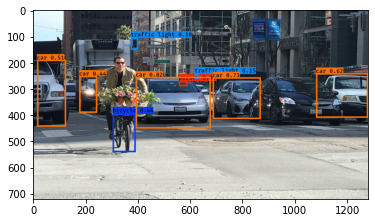

In [15]:
out_scores, out_boxes, out_classes = predict(sess, "test1.jpeg")

Found 1 boxes for cartest3.jpg
car 0.90 (393, 278) (904, 477)


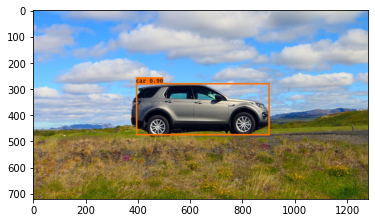

In [16]:
out_scores, out_boxes, out_classes = predict(sess, "cartest3.jpg")

Found 67 boxes for testcar1.jpeg
car 0.05 (728, 145) (781, 185)
car 0.05 (529, 108) (583, 144)
car 0.06 (26, 113) (99, 238)
car 0.07 (948, 82) (1000, 126)
car 0.07 (550, 143) (608, 191)
car 0.08 (878, 86) (927, 124)
car 0.12 (725, 82) (793, 124)
car 0.13 (617, 36) (663, 69)
car 0.13 (215, 36) (262, 70)
car 0.17 (539, 37) (591, 71)
truck 0.18 (1122, 22) (1213, 70)
car 0.19 (684, 36) (731, 69)
car 0.19 (592, 105) (659, 145)
car 0.19 (1237, 107) (1280, 154)
person 0.20 (171, 244) (193, 278)
car 0.20 (403, 34) (461, 72)
car 0.21 (257, 80) (328, 129)
car 0.23 (262, 34) (321, 71)
car 0.26 (1017, 69) (1108, 123)
car 0.27 (470, 38) (523, 72)
car 0.27 (821, 37) (872, 71)
car 0.27 (443, 614) (605, 720)
car 0.27 (755, 38) (809, 70)
car 0.27 (1240, 560) (1280, 682)
car 0.28 (1217, 253) (1280, 322)
car 0.29 (33, 333) (65, 373)
car 0.31 (884, 34) (939, 67)
car 0.31 (93, 29) (142, 71)
car 0.31 (671, 103) (726, 144)
car 0.31 (1072, 36) (1122, 70)
truck 0.32 (272, 618) (423, 720)
car 0.32 (1008, 36) (1

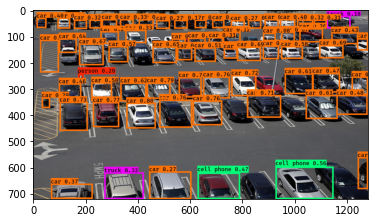

In [17]:
out_scores, out_boxes, out_classes = predict(sess, "testcar1.jpeg")